# ImpNet

Convolutional NN to improve the quality of MRI 
images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

Due to memory issues I will only select half of the images

select = np.random.choice(np.arange(0, 4055), size = 2000)

In [63]:
X = np.load('/home/cloud/MRT_Data/unziped/out/P2_X.npy')

In [64]:
X = X.reshape([4055, 256, 256, 1])

X = X[select, :, :]

In [6]:
gc.collect()

14

 Normalize data

In [65]:
Y = np.load('/home/cloud/MRT_Data/unziped/out/P2_Y.npy')

In [66]:
Y = Y.reshape([4055, 256, 256, 1])

Y = Y[select, :, :]

clean up the mess

In [ ]:
gc.collect()

55674

# Create train and test and validation set

In [ ]:
train_frac = 0.8

In [ ]:
train_index = int(train_frac * Y.shape[0])

In [ ]:
X_train = X[0:train_index,:,:,:]
X_eval = X[train_index:X.shape[0],:,:,:]

In [ ]:
Y_train = Y[0:train_index,:,:]
Y_eval = Y[train_index:X.shape[0],:,:,:]

# Create and train CNN

Create the CNN model

In [57]:
def cnn_model_fn(features, labels, mode):
    
    # Input Layer
    input_layer = features['x']
    
    # Convolutional layer #1
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 64,
        strides = 2,
        kernel_size = 5,
        padding = "same",
        activation= tf.nn.relu,
        name = "Convolution_Layer_1")

    
    # Convolutional layer #2
    conv2 = tf.layers.conv2d(
        inputs = conv1,
        filters = 128,
        strides = [2, 2],
        kernel_size = [5, 5],
        padding = "same",
        name = "Convolution_Layer_2")
    
    # Convolutional layer #3
    conv3 = tf.layers.conv2d(
        inputs = conv2,
        filters = 256,
        strides = [2, 2],
        kernel_size = [5, 5],
        padding = "same",
        activation = tf.nn.relu,
        name = "Convolution_Layer_3")
    
    
    # Deconvolutional layer #1
    deconv1 = tf.layers.conv2d_transpose(
        inputs = conv3,
        filters = 256,
        strides = [2, 2],
        kernel_size = [5, 5],
        padding = "same",
        name = "Deconvolution_Layer_1")
    
    
    # Deconvolutional layer #2
    deconv2 = tf.layers.conv2d_transpose(
        inputs = deconv1,
        filters = 128,
        strides = [2, 2],
        kernel_size = [5, 5],
        padding = "same",
        name = "Deconvolution_Layer_2")
    
    # Deconvolutional layer #3
    deconv3 = tf.layers.conv2d_transpose(
        inputs = deconv2,
        filters = 64,
        strides = [2, 2],
        kernel_size = [5, 5],
        padding = "same", 
        name = "Deconvolution_Layer_3")
    
    # final covolution to get to 3 layers
    conv4 = tf.layers.conv2d(
        inputs = deconv3,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = tf.nn.relu,
        name = "Prediction")

    # Calculate predictions
    predictions = conv4
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=predictions)
    
    # Calculate Loss (for both Train and EVAL modes)
    loss = tf.losses.absolute_difference(labels = labels, predictions = conv4)
    tf.summary.scalar("Value_Loss_Function", loss)

    for var in tf.trainable_variables():
        tf.summary.histogram(var.name, var)
    merged_summary = tf.summary.merge_all()
        
    # Configure the Training OP (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
    # Add evaluation metrics
    eval_metric_ops = {
        "accuracy": tf.metrics.mean_absolute_error(
            labels=labels, predictions=predictions)}
    return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)    


Load train and test data

In [ ]:
train_data = X_train
train_labels = Y_train
eval_data = X_eval
eval_labels = Y_eval

Create the estimator

In [ ]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 10)

In [ ]:
ImpNet = tf.estimator.Estimator(config=runconf,
    model_fn=cnn_model_fn, model_dir="/tmp/ImpNet",
        
    )

INFO:tensorflow:Using config: {'_model_dir': '/tmp/ImpNet', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff28650da58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

logging_hook = tf.train.SummarySaverHook(
     save_steps= 1,
    output_dir="/home/cloud/Training/summary_hook", 
    scaffold=tf.train.Scaffold(summary_op=tf.summary.merge_all())) 

Train the model

In [ ]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=40,
    num_epochs=None,
    shuffle=True)

In [ ]:
ImpNet.train(
    input_fn=train_input_fn,
    steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Summary name Convolution_Layer_1/kernel:0 is illegal; using Convolution_Layer_1/kernel_0 instead.
INFO:tensorflow:Summary name Convolution_Layer_1/bias:0 is illegal; using Convolution_Layer_1/bias_0 instead.
INFO:tensorflow:Summary name Convolution_Layer_2/kernel:0 is illegal; using Convolution_Layer_2/kernel_0 instead.
INFO:tensorflow:Summary name Convolution_Layer_2/bias:0 is illegal; using Convolution_Layer_2/bias_0 instead.
INFO:tensorflow:Summary name Convolution_Layer_3/kernel:0 is illegal; using Convolution_Layer_3/kernel_0 instead.
INFO:tensorflow:Summary name Convolution_Layer_3/bias:0 is illegal; using Convolution_Layer_3/bias_0 instead.
INFO:tensorflow:Summary name Deconvolution_Layer_1/kernel:0 is illegal; using Deconvolution_Layer_1/kernel_0 instead.
INFO:tensorflow:Summary name Deconvolution_Layer_1/bias:0 is illegal; using Deconvolution_Layer_1/bias_0 instead.
INFO:tensorflow:Summary name Deconvolution_Layer_2/kernel:0 is

## Evaluate the model

Make predictions

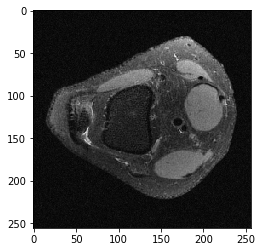

In [79]:
plt.imshow(Y_eval[100,:,:,0], cmap='gray' )

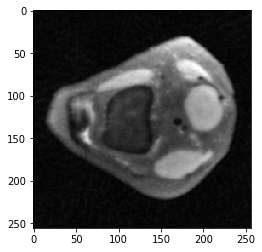

In [80]:
plt.imshow(X_eval[100,:,:,0], cmap='gray' )

This is an original image. What does our network predict?

In [81]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_eval[100:101,:,:,:]},
    y=X_eval[1:2,:,:,:],
    num_epochs=1,
    shuffle=False)
predict_results = ImpNet.predict(input_fn=predict_input_fn)
predict_results = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/ImpNet/model.ckpt-2664
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


The first dictionary is the image shown above. Although I cannot see much in the picture the network is 99.8% sure that it is original!

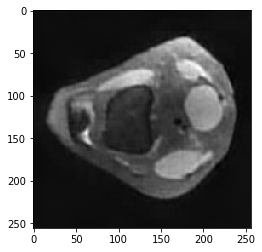

In [82]:
plt.imshow(predict_results[0][:,:,0], cmap='gray')